In [1]:
CHECKPOINT = "spectral-u-net-waveglow-compat-cyclic-lr-1577119068.full.ckpt"

In [2]:
branch_suffix = '-'.join(CHECKPOINT.replace('spectral-u-net-', '').split('-')[0:-1])
branch = f'train/{branch_suffix}'
print(branch)

train/waveglow-compat-cyclic-lr


In [3]:
%%bash -s $branch
cd ../../speech-enhancement
git checkout $1

M	src/datasets/speech/noisy_speech/speech_dataset_spectral.py
Your branch is up to date with 'origin/train/waveglow-compat-cyclic-lr'.


Already on 'train/waveglow-compat-cyclic-lr'


In [4]:
import torch
from IPython.display import Audio

from src.datasets import NoisySpectralSpeechDataset
from src.utils import checkpoint, spectral
USE_CUDA = True

In [5]:
NoisySpectralSpeechDataset.MAX_AUDIO_LENGTH = 47360 * 2

In [6]:
dataset = NoisySpectralSpeechDataset(train=False, quiet=True)

In [7]:
net = checkpoint.load(CHECKPOINT, use_cuda=USE_CUDA)
net = net.eval()

In [8]:
waveglow = spectral.load_waveglow(use_cuda=USE_CUDA)

Using cache found in /home/matt/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [87]:
# Sample data
IDX = 112
noisy_spectral, clean_spectral = dataset[IDX]
noisy_arr = dataset.noisy_data[IDX]
clean_arr = dataset.clean_data[IDX]

In [88]:
# Predict clean spectrum
noisy_spectral_batch = noisy_spectral.view(1, 1, 80, -1).cuda()
with torch.no_grad():
    pred_clean_spectral_batch = net(noisy_spectral_batch)

pred_clean_spectral = pred_clean_spectral_batch.view(1, 80, -1)
pred_clean_spectral.shape

torch.Size([1, 80, 512])

In [89]:
audio_arr = spectral.waveglow_spec_to_audio(pred_clean_spectral, waveglow)

In [90]:
clean_rec_arr = spectral.waveglow_spec_to_audio(clean_spectral.cuda(), waveglow)

In [91]:
from librosa.display import specshow
import matplotlib.pyplot as plt

def plot_spec(spec_t, sr):
    spec = spec_t.view(80, -1).cpu().detach().numpy()
    plt.figure(figsize=(10, 4))
    specshow(spec, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar()
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

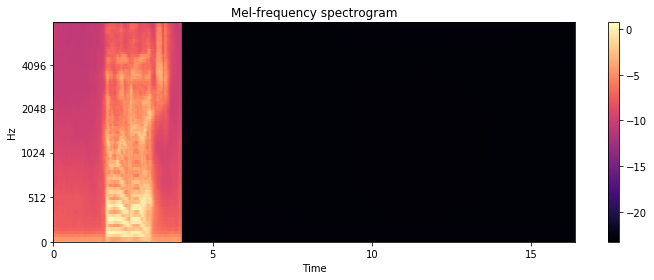

In [92]:
plot_spec(pred_clean_spectral, sr=16000)

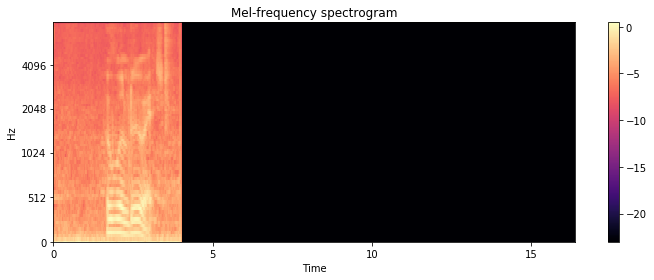

In [93]:
plot_spec(noisy_spectral, sr=16000)

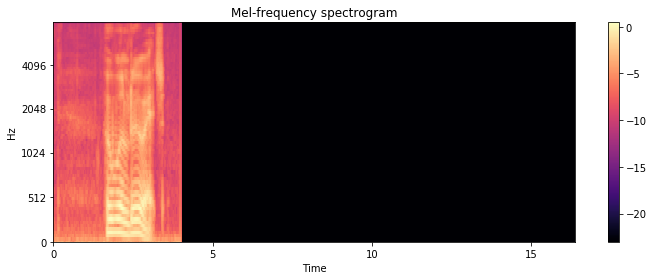

In [94]:
plot_spec(clean_spectral, sr=16000)

In [96]:
Audio(audio_arr, rate=22050)

In [97]:
Audio(noisy_arr, rate=16000)

In [98]:
Audio(clean_arr, rate=16000)

In [99]:
Audio(clean_rec_arr, rate=22050)

In [100]:
# Reconstruct with Griffin-Lim
import numpy as np
from librosa.feature.inverse import mel_to_audio
SAMPLING_RATE = 16000
WAVEGLOW_BINS = 80
WAVEGLOW_N_FFT = 1024  # timesteps
WAVEGLOW_HOP = 256  # timesteps
WAVEGLOW_WINDOW = 1024  # timesteps
WAVEGLOW_SAMPLING_RATE = 22050
WAVEGLOW_SPEC_KWARGS = {
    "sr": SAMPLING_RATE,
    "n_fft": WAVEGLOW_N_FFT * SAMPLING_RATE // WAVEGLOW_SAMPLING_RATE + 1,
    "hop_length": WAVEGLOW_HOP * SAMPLING_RATE // WAVEGLOW_SAMPLING_RATE,
    "win_length": WAVEGLOW_WINDOW * SAMPLING_RATE // WAVEGLOW_SAMPLING_RATE + 1,
    "window": "hann",
    "center": True,
    "pad_mode": "reflect",
    "power": 1,
}

clean_rec_arr = mel_to_audio(
    np.exp(clean_spectral.cpu().detach().view(80, -1).numpy()),
    n_iter=60,
    **WAVEGLOW_SPEC_KWARGS
)
Audio(clean_rec_arr, rate=16000)